In [2]:
import warnings
import math
import db_func
import pandas as pd
import numpy as np
from bokeh.plotting import figure, show
from bokeh.io import output_notebook, push_notebook, show
import matplotlib.pyplot as plt
from datetime import date, datetime
from tqdm.notebook import tqdm
import re
from sklearn.preprocessing import StandardScaler
warnings.filterwarnings('ignore')


In [15]:
match_df = pd.read_csv('all_matches.csv')

In [20]:
match_df['home_3pa'].describe()

count    19158.000000
mean         6.129069
std          2.252256
min          0.750000
25%          4.500000
50%          6.000000
75%          7.750000
max         15.849057
Name: home_3pa, dtype: float64

In [23]:
match_df[match_df['home_3pa'].isnull()]

,match_id,away_id,home_id,date,away_pts,home_pts,playoff_game,home_ml,away_ml,home_spread,...,prev_home_efg_pct_sma3,prev_home_efg_pct_ema3,favorite,favorite_won,past_3_home_favorite_wins,past_3_away_favorite_wins,home_elo,away_elo,prev_home_elo,prev_away_elo


### Three Point Attempts Made Per 10 Minutes by Season

In [33]:
def plot_historical_rate(stat='', ylabel=''):
	grouped = match_df.groupby(['season'])
	dataframes = [group for _, group in grouped]
	y = []
	medians = []
	for i in range(len(dataframes)):
		y.append(dataframes[i].apply(lambda x: \
			(x['home_'+ stat] + x['away_'+stat]), axis=1))
		#y[i] = y[i].apply(lambda x: (x-y[i].mean())/ y[i].std())
		medians.append(y[i].mean())

	x = match_df['season'].unique()

	fig, ax1 = plt.subplots(figsize=(15, 7))
	plt.boxplot(y)
	ax1.set_xticklabels(x)

	ax1.yaxis.grid(True, linestyle='-', which='major', color='lightgrey',
				alpha=0.5)

	ax1.set_axisbelow(True)
	ax1.set_title(ylabel)
	ax1.set_xlabel('Season')
	ax1.set_ylabel(ylabel)
	top = max([df.max() for df in y]) + 3
	bottom = 0
	ax1.set_ylim(bottom, top)
	ax1.set_xlim(0.5, len(medians) + 0.5)
	pos = np.arange(len(medians)) + 1
	for i in range(len(medians)):
		ax1.text(pos[i], top - (top *0.05), round(medians[i],2),
				horizontalalignment='center', size='small')
	plt.show()


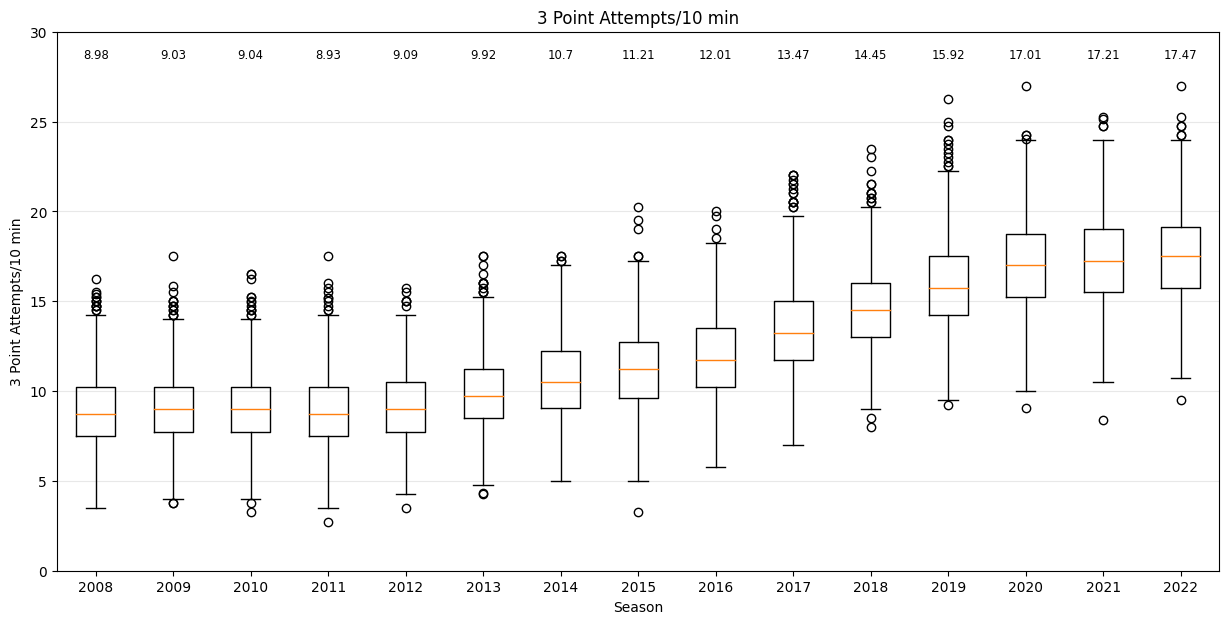

In [34]:
plot_historical_rate('3pa', 
	'3 Point Attempts/10 min')

In [19]:
plot_historical_rate('ft', 'Free Throws Attempts/10 Minutes')

KeyError: 'home_ft'

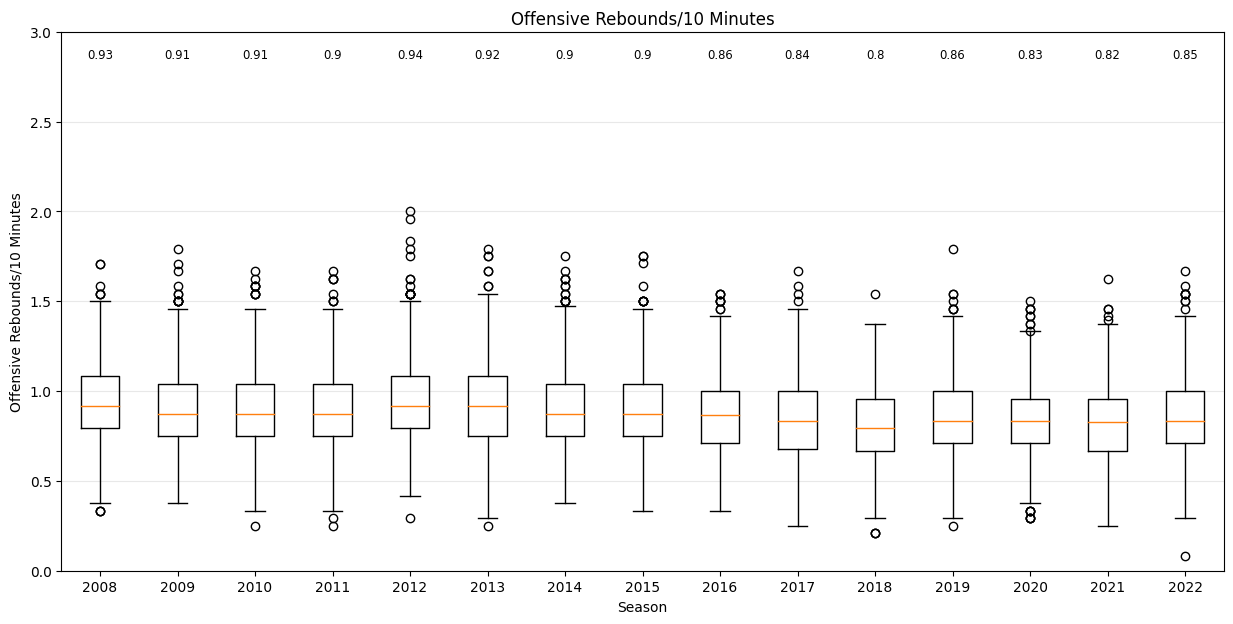

In [114]:
plot_historical_rate('orb', 'Offensive Rebounds/10 Minutes')

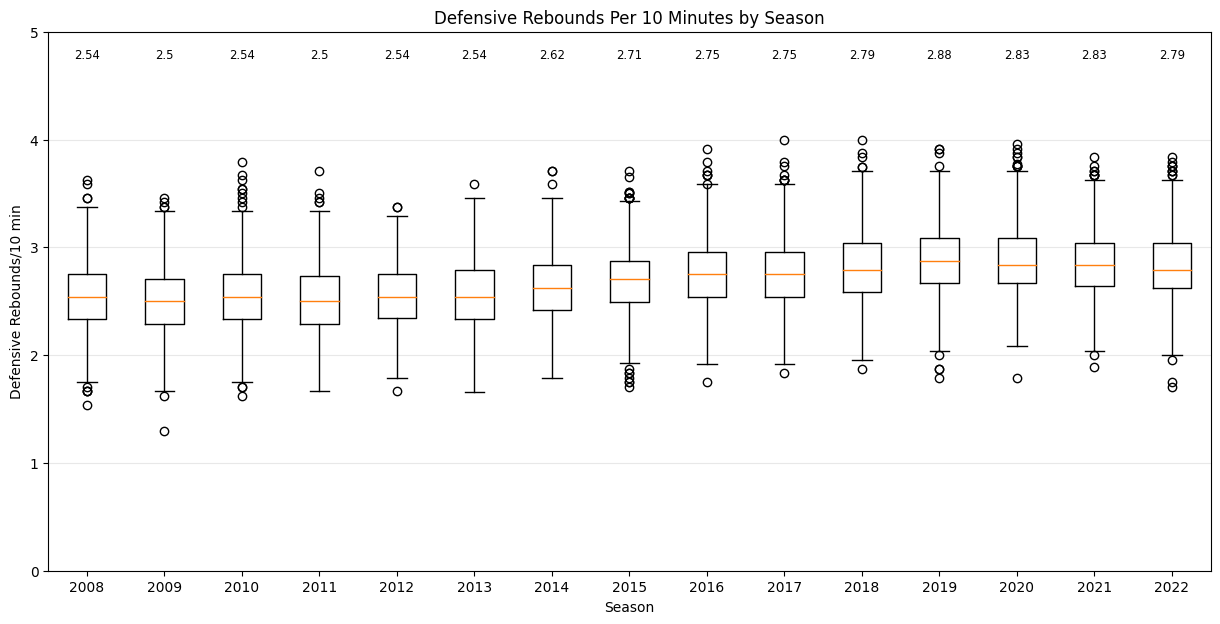

In [88]:
plot_historical_rate('drb', 'Defensive Rebounds/10 Minutes')

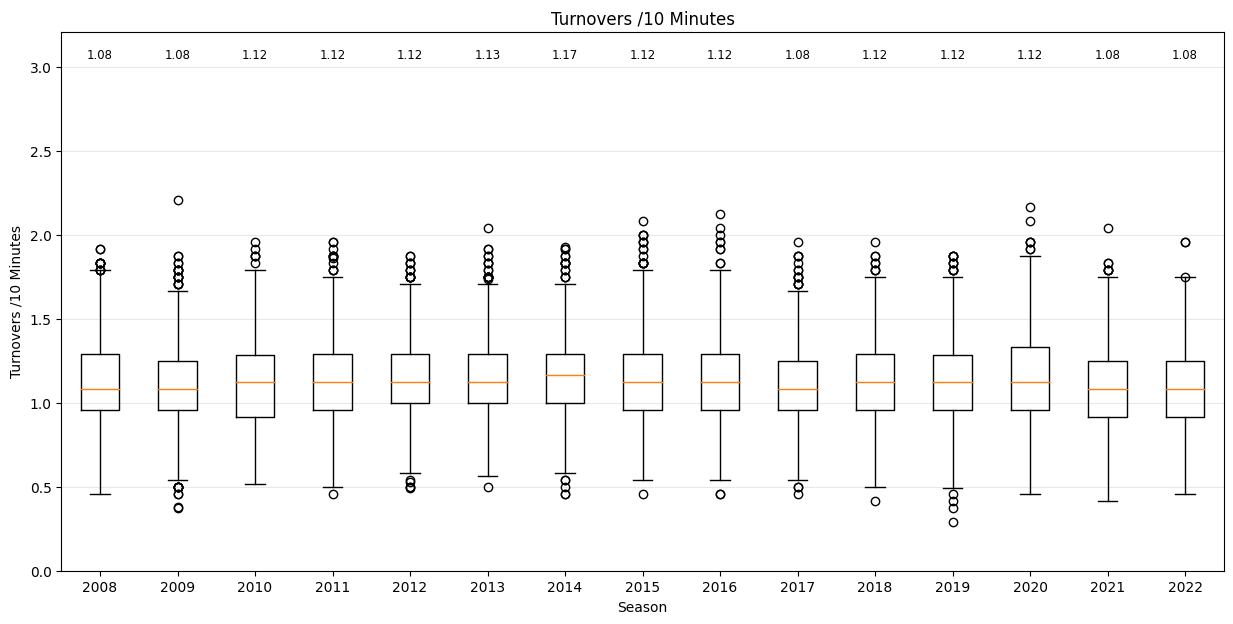

In [110]:
plot_historical_rate('tov','Turnovers /10 Minutes')

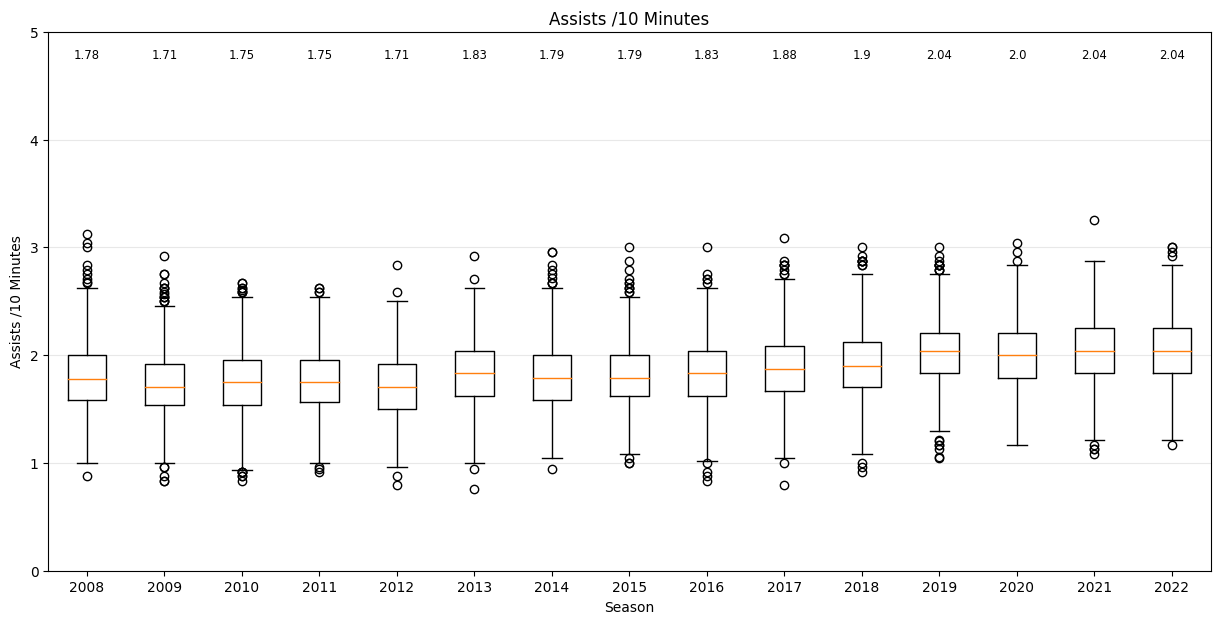

In [91]:
plot_historical_rate('ast','Assists /10 Minutes')


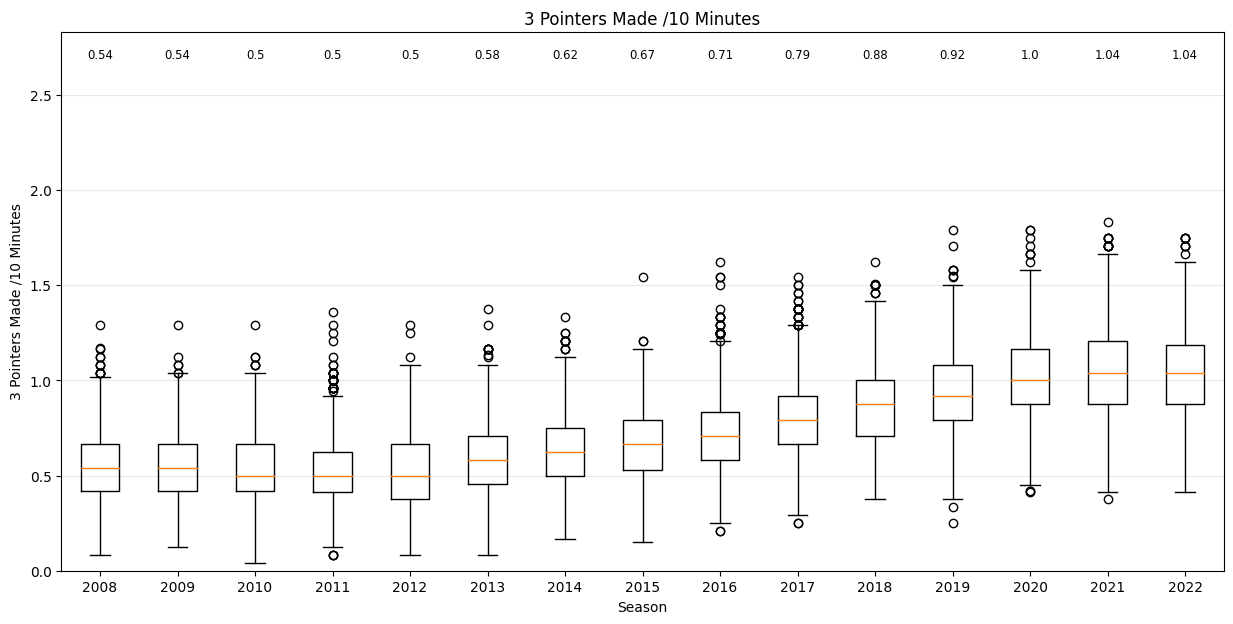

In [108]:
plot_historical_rate('3p','3 Pointers Made /10 Minutes')


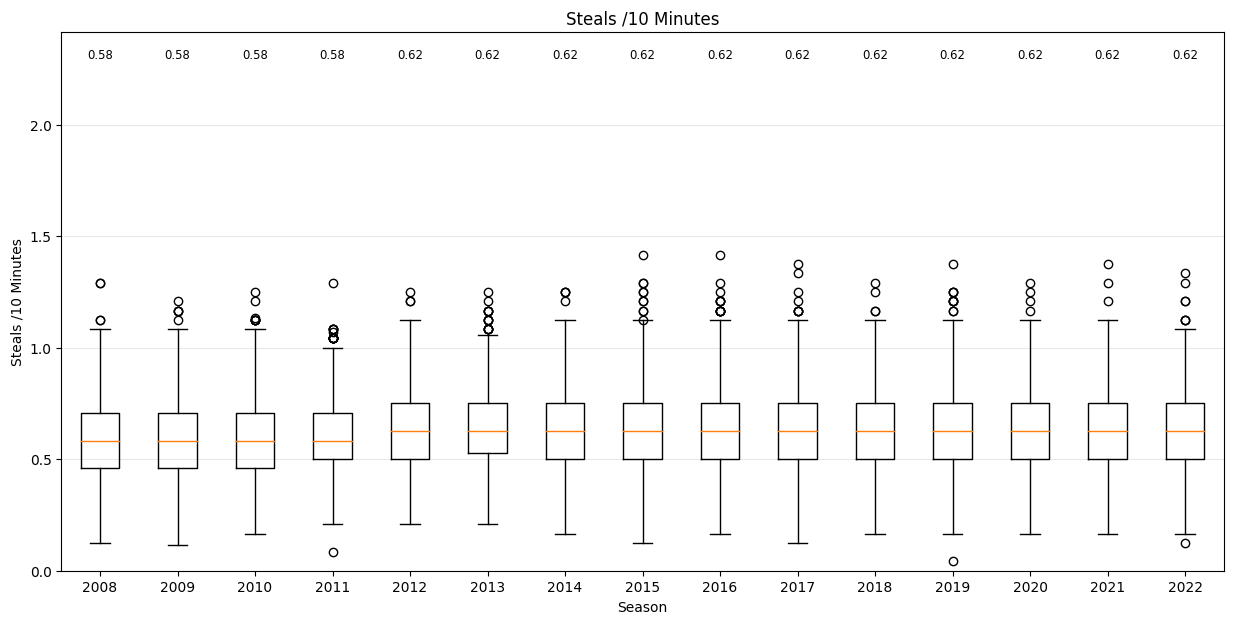

In [107]:
plot_historical_rate('stl','Steals /10 Minutes')


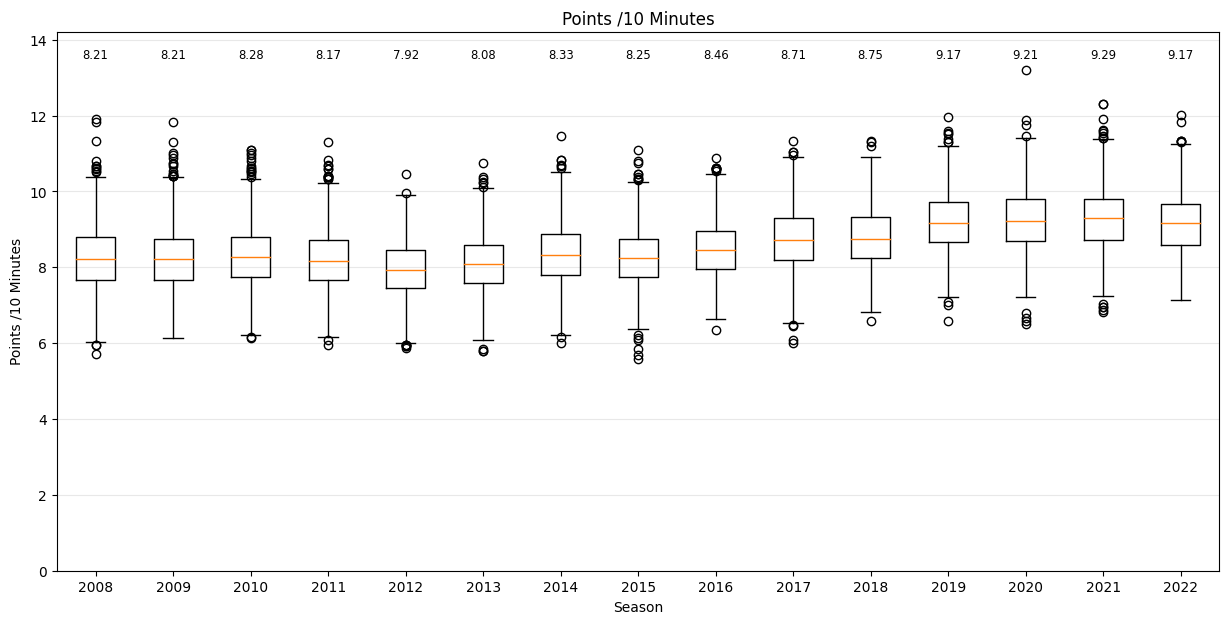

In [109]:
plot_historical_rate('pts','Points /10 Minutes')


### PCA

In [208]:
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
match_df = pd.read_csv('all_matches.csv')
match_df.dropna(inplace=True)
non_relevant_cols = ['movl', 'season', 'match_id', 'away_id', 'home_id', 
	'home_spread','away_spread', 'home_ps_odds', 'away_ps_odds', 'over', 'under', 
	'date', 'playoff_game', 'favorite', 'favorite_won', 'sp', 'spread']
X = match_df[match_df.columns.difference(non_relevant_cols)]
#X = match_df[['home_3pa', 'away_3pa', 'away_ast', 'home_ast']]
y = match_df.movl
# Z-score the features

X_scaled = scaler.fit_transform(X)

# The PCA model
pca = PCA(n_components=2) 
#X_new = pca.fit(X_scaled) # project the original data into the PCA space

In [199]:
components = pca.fit_transform(X_scaled)
components = pd.DataFrame(components).transpose()
print(components)

      0         1          2         3         4         5         6      \
0 -2.687169 -4.335272 -12.274647 -7.778303 -9.390033 -7.749524 -9.214961   
1 -4.755714  0.961391   1.911864  6.402959 -0.215357  1.665462  4.142166   

      7         8         9      ...     18538      18539     18540     18541  \
0 -7.733076 -7.230487 -3.569749  ... -4.059906  11.830857 -6.183584 -6.637474   
1  5.528888  1.554317  0.467318  ... -2.173649  -2.934937 -4.173886 -6.259815   

      18542     18543     18544     18545     18546     18547  
0  6.079335  9.989959  8.307616  5.360798  0.141696 -3.272684  
1 -1.115084 -1.114636 -1.599551 -4.053658 -8.386284 -8.432306  

[2 rows x 18548 columns]


In [195]:
var_ratio = pca.explained_variance_ratio_
var_ratio= pd.DataFrame(var_ratio).transpose()
var_ratio.columns = ['Comp1', 'Comp2']
var_ratio.index = ['Proportion of Variance']
print(var_ratio)

                           Comp1    Comp2
Proportion of Variance  0.109797  0.04423


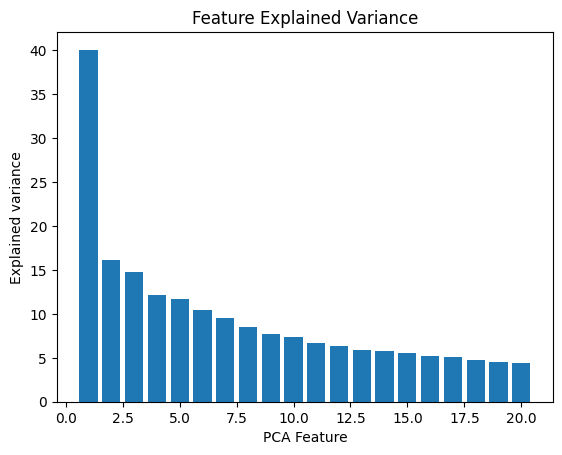

In [190]:
plt.bar(
    range(1,len(pca.explained_variance_)+1),
    pca.explained_variance_
    )
plt.xlabel('PCA Feature')
plt.ylabel('Explained variance')
plt.title('Feature Explained Variance')
plt.show()